In [4]:
import numpy as np

from scipy.optimize import curve_fit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from tqdm import tqdm

from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter, ParameterVector

In [5]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper


def compute_H(eps, t, delta, num_sites):

    H = 0
    for site in range(num_sites - 1):
        H += (eps[site]+eps[site+1]) / 2 * ((I ^ I))
        H += -(eps[site]) / 2 * (I ^ Z)
        H += -(eps[site+1]) / 2 * (Z ^ I)
        H += (t + delta) / 2 * (X ^ X)
        H += (t - delta) / 2 * (Y ^ Y)

    return H


# Example computation. This Hamiltonian is the same model we cover in the paper and will persist through the notebook.
num_sites = 2

# Parameterized hopping strengths
eps = ParameterVector("ε", num_sites)
t = Parameter("t")
delta = Parameter("Δ")
H_param = compute_H(eps, t, delta, num_sites)

# Select specific tau and tau_d values
H = H_param.bind_parameters({eps: np.ones(num_sites), t: 1, delta: 1})

# Print Hamiltonian operators to confirm it's what we expect
H

SummedOp([PauliOp(Pauli('II'), coeff=1.0), PauliOp(Pauli('IZ'), coeff=-0.5), PauliOp(Pauli('ZI'), coeff=-0.5), PauliOp(Pauli('XX'), coeff=1.0), PauliOp(Pauli('YY'), coeff=0.0)], coeff=1.0, abelian=False)

In [6]:
# Define a list of number operators in terms of Pauli operators
n_is = [
    1 / 2 * ((I ^ num_sites) - ((I ^ i) ^ Z ^ (I ^ (num_sites - i - 1))))
    for i in range(num_sites)
]
n_is

[PauliSumOp(SparsePauliOp(['II', 'ZI'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0),
 PauliSumOp(SparsePauliOp(['II', 'IZ'],
               coeffs=[ 0.5+0.j, -0.5+0.j]), coeff=1.0)]

### Classical Simulation
We can now classically simulate the state evolution and measure the observables of interest.

In [7]:
from qiskit.opflow import Suzuki


def compute_U_trot(H, time, trotter_steps, order=1):
    """
    Apply the Suzuki-Trotter approximation to the Hamiltonian H to compute a trotterized unitary time evolution operator.

    Args:
        H - OperatorBase (such as SummedOp); Hamiltonian governing time dynamics.
        time - float or Parameter; time of evolution under Hamtilonian H.
        tortter_steps - int; number of trotter_steps.
        order - int; order of Suzuki-Trotterization approximation to use when approximating H.

    Returns:
        U_trot - ComposeOp; The Trotterized time evolution operator
    """

    U_trot = Suzuki(trotter_steps, order=order).convert(time * H)
    return U_trot


# # Print example output
# compute_U_trot(H, 1, 20)

# times = np.linspace(0, 4 * np.pi, 50)
# # Print example output
# compute_U_trot(H, times[0], 2)
H

SummedOp([PauliOp(Pauli('II'), coeff=1.0), PauliOp(Pauli('IZ'), coeff=-0.5), PauliOp(Pauli('ZI'), coeff=-0.5), PauliOp(Pauli('XX'), coeff=1.0), PauliOp(Pauli('YY'), coeff=0.0)], coeff=1.0, abelian=False)

In [8]:
# Time evolution calculation using same parameters as the exact classical calculation

# Initial state on the far left (same as before)
initial_state = One ^ (Zero ^ (num_sites - 1))

# Define array of time points (technically these are relative to the hopping terms)
#times = np.linspace(0, 12 * np.pi, 150)
times = np.linspace(0, 4 * np.pi, 50)

# Number of trotter steps
trotter_steps = 8

# Calculate each number operator's expectation value at each time point and store in a 2D array
evo_matrix_trot = np.zeros((len(times), num_sites))
for i, ni in enumerate(tqdm(n_is)):
    for j, time in enumerate(times):
        U = compute_U_trot(H, time, trotter_steps)
        final_state = U @ initial_state
        evo_matrix_trot[j, i] = np.abs(
            (final_state.adjoint() @ ni @ final_state).eval()
        )

100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


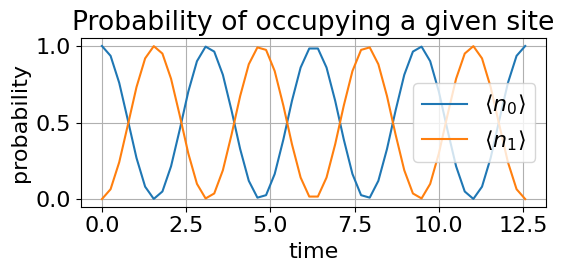

In [9]:
# Plot the time evolution
# list of labels for the plot
num_op_labels = [r"$\langle n_" + str(i) + "\\rangle$" for i in range(num_sites)]

plt.figure(figsize=(6, 3))
plt.plot(times, evo_matrix_trot)
plt.xlabel("time")
plt.ylabel("probability")
plt.title("Probability of occupying a given site")
plt.grid()
plt.legend(num_op_labels)
plt.tight_layout()
plt.savefig("figures/2-site-pmm/2-pmm-site-prob.pdf")
plt.show()

Let's try another kind of plot to get a sense for how the particle moves across the lattice over time.

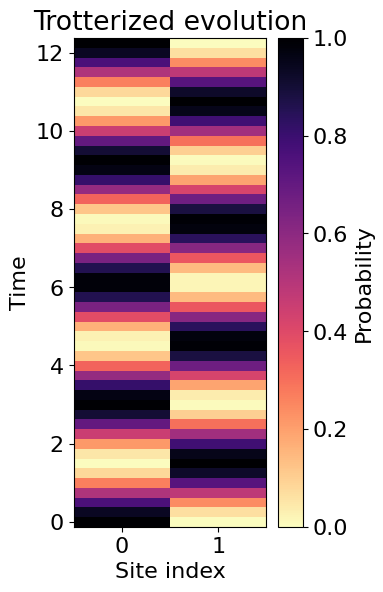

In [10]:
plt.figure(figsize=(4, 6))
plt.imshow(
    evo_matrix_trot, origin="lower", aspect="auto", vmin=0, vmax=1, cmap="magma_r"
)
plt.xticks(np.arange(num_sites), labels=np.arange(num_sites))
plt.yticks(
    np.arange(0, evo_matrix_trot.shape[0], 8), labels=np.arange(0, 4 * np.pi, 2).astype(int)
)
plt.ylabel("Time")
plt.xlabel("Site index")
cbar = plt.colorbar()
cbar.set_label("Probability")
plt.tight_layout()
plt.title("Trotterized evolution")
plt.savefig("figures/2-site-pmm/2-pmm-trott-evol.pdf")
plt.show()

#### Particle conservation check

It's always a good idea to test if a computer is giving something that makes sense. One such test, and a rather low effort one, is to compute the probability of finding the particle across all sites at each time point. Since we know there is only one particle to begin with and particle number is conserved, we should calculate 1 for all time steps. We will later use this fact in post-processing our quantum computer data by throwing out any measurements that don't preserve particle number.

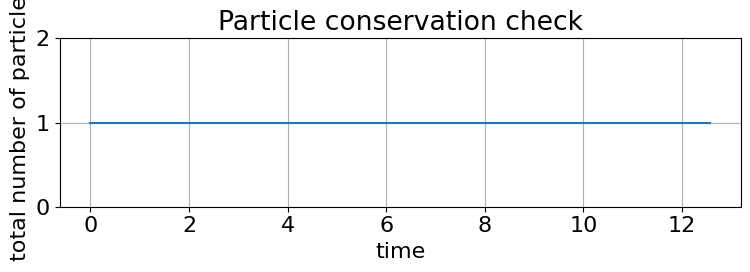

In [11]:
# Check that at each time point, the total number of particles is constant
plt.figure(figsize=(8, 3))
plt.plot(times, np.sum(evo_matrix_trot, axis=1))
plt.xlabel("time")
plt.ylabel("total number of particles")
plt.title("Particle conservation check")
plt.ylim([0, 2])
plt.grid()
plt.tight_layout()
plt.savefig("figures/2-site-pmm/2-pmm-particle-cons-check.pdf")
plt.show()

In [12]:
from qiskit.opflow import PauliTrotterEvolution

# Define some useful function used later on in this section


def convert_U_trot_to_qc(U_trot):
    """
    Convert the U_trot ComposedOp object returned by compute_U_trot() to a bare quantum circuit.

    Tutorial on using PauliTrotterEvolution at
    https://github.com/Qiskit/qiskit/blob/stable/0.46/docs/tutorials/operators/01_operator_flow.ipynb#

    Args:
        U_trot - OperatorBase (such as ComposedOp); Trotterized unitary time evolution operator to be written in terms of a quantum circuit.

    Returns:
        qc_trot - QuantumCircuit; The trotterized quantum circuit associated with U_trot. The gates are decomposed down to single and two-qubit gates.
    """

    qc_trot = PauliTrotterEvolution().convert(U_trot)
    return (
        qc_trot.to_circuit().decompose().decompose()
    )  # add decompose methods so gates are not abstracted unitary blocks

In [13]:
U1 = compute_U_trot(H, time, 1) #Example Trotterization
qc = convert_U_trot_to_qc(U1)

latex_code = qc.draw("latex_source")
print(latex_code)
with open("circuits/2-pmm-circuit.tex", "w") as f:
    f.write(latex_code)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \ctrl{1} & \qw & \ctrl{1} & \gate{\mathrm{R_X}\,(\mathrm{\frac{-\pi}{2}})} & \gate{\mathrm{H}} & \ctrl{1} & \qw & \ctrl{1} & \gate{\mathrm{H}} & \gate{\mathrm{U_3}\,(\mathrm{0,0,-4\pi})} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{R_X}\,(\mathrm{\frac{\pi}{2}})} & \targ & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \targ & \gate{\mathrm{R_X}\,(\mathrm{\frac{-\pi}{2}})} & \gate{\mathrm{H}} & \targ & \gate{\mathrm{R_Z}\,(\mathrm{8\pi})} & \targ & \gate{\mathrm{H}} & \gate{\mathrm{U_3}\,(\mathrm{0,0,-4\pi})} & \qw & \qw\\
\\ }}
\end{document}


### Calculating the exact solution

In [14]:
# Time evolution operator for a Hamiltonian H and time time_param
def compute_U(H, t):
    """
    Compute the time evolution operator.

    Args:
        H - OperatorBase (such as SummedOp); the Hamiltonan under which you wish to time evolve.

    Returns:
        U - EvolvedOp; The time evolution operator parameterized by variable 't'
    """
    U = (H * t).exp_i()
    return U

# Calculation of each number operator's expectation value over time
times = np.linspace(0, 20 * np.pi, 50)

# Initial state on the far left of the 1D lattice
initial_state = One ^ Zero
# Define array of time points (technically these are relative to the hopping terms)

# Calculation each number operator's expectation value at each time point
# Initialize a 2D array which we will fill with each site's expectation value (columns) and at each time point (rows)
evo_matrix = np.zeros((len(times), num_sites))
# Initialize 1D array to fill in variance of the sum of the number operators
var_matrix = np.zeros(len(times))

for i, time in enumerate(tqdm(times)):
    for j, ni in enumerate(n_is):
        # Compute the time evolution operator U(time) at time time
        U = compute_U(H, time)
        # Compute the evolution of the initial state
        final_state = U @ initial_state
        # Compute the expectation value n_i
        evo_matrix[i, j] = np.abs((final_state.adjoint() @ ni @ final_state).eval())
    var_matrix[i] = (
        np.abs((final_state.adjoint() @ (sum(n_is) @ sum(n_is)) @ final_state).eval())
        - np.abs((final_state.adjoint() @ sum(n_is) @ final_state).eval()) ** 2
    )

100%|██████████| 50/50 [00:00<00:00, 96.41it/s] 


The evolution above looks quite similar the exact evolution, but not quite. This is due to trotter error.

### Trotter Error
The Suzuki-Trotter approximation is just that: an approximation. To illustrate how this might affect estimating the exact dynamics, let's plot the evolution of the exact solution with various trotter steps.

In [15]:
# Number of trotter steps
trotter_steps_5 = 1
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_5 = np.zeros((len(times), num_sites))
for i, ni in enumerate(tqdm(n_is)):
    for j, time in enumerate(times):
        U = compute_U_trot(H, time, trotter_steps_5)
        final_state = U @ initial_state
        evo_matrix_trot_5[j, i] = np.abs(
            (final_state.adjoint() @ ni @ final_state).eval()
        )

# Number of trotter steps
trotter_steps_8 = 2
# Calculate each number operator's expectation value at each time point
evo_matrix_trot_8 = np.zeros((len(times), num_sites))
for i, ni in enumerate(tqdm(n_is)):
    for j, time in enumerate(times):
        U = compute_U_trot(H, time, trotter_steps_8)
        final_state = U @ initial_state
        evo_matrix_trot_8[j, i] = np.abs(
            (final_state.adjoint() @ ni @ final_state).eval()
        )

100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


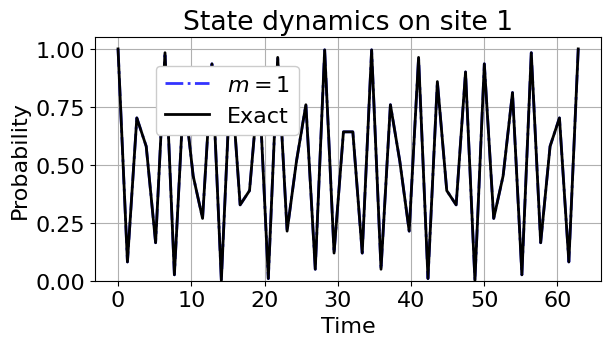

In [16]:
# Plot state dynamics over one particular site
site = 0

plt.figure(figsize=(6.25, 3.75))
plt.plot(
    times,
    evo_matrix_trot_5[:, site],
    "b-.",
    linewidth=2,
    label=rf"$m={trotter_steps_5}$",
    markerfacecolor="royalblue",
    alpha=0.8,
)
# plt.plot(
#     times,
#     evo_matrix_trot_8[:, site],
#     "r--",
#     linewidth=2,
#     label=rf"$m={trotter_steps_8}$",
#     markerfacecolor="salmon",
#     alpha=0.8,
# )
plt.plot(
    times, evo_matrix[:, site], "k-", linewidth=2, label="Exact", markerfacecolor="grey"
)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc=(0.12, 0.6), framealpha=1)
plt.tight_layout()
plt.title("State dynamics on site " + str(site+1))
plt.tight_layout()
plt.savefig("figures/2-site-pmm/2-pmm-state_dynm_site0.pdf")
plt.show()